In [140]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import datetime

import json # library to handle JSON files
%matplotlib inline

In [31]:
# import the data set
df = pd.read_csv('/Users/no50free/GitHub/NiceRide/201908-niceride-tripdata.csv')

In [2]:
df.head(3)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type
0,811,2019-08-01 00:00:44.8830,2019-08-01 00:14:16.2140,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,-93.255799,262,Subscriber,1991,2,Classic
1,99,2019-08-01 00:00:48.1090,2019-08-01 00:02:27.5170,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,-93.276435,477,Subscriber,1990,2,Classic
2,1205,2019-08-01 00:02:34.2950,2019-08-01 00:22:39.7020,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,24,Customer,1994,1,Classic


In [99]:
# import weather data

df_weather = pd.read_csv('/Users/no50free/GitHub/NiceRide_network_analysis/data/weather_2019.csv')
df_weather.head()

,Unnamed: 0,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation
0,0,2019-04-22,11:53 PM,49,13,40,0.0
1,1,2019-04-22,12:53 AM,49,13,40,0.0
2,2,2019-04-22,1:53 AM,48,14,40,0.0
3,3,2019-04-22,2:53 AM,46,14,41,0.0
4,4,2019-04-22,3:53 AM,46,13,41,0.0


In [ ]:
# Create a datetime column in the weather dataframe
for j in df_weather.index:
    df_weather.loc[j, 'DateTime'] = pd.to_datetime(df_weather.Day[j] +' '+ df_weather.Time[j])

The way that the data is presented on Wunderground puts the 11:53 PM time on the next day. That is, the first entry in the table when you look up history for August 2, say, is 11:53PM August 1. So when I scraped the data, the entries for 11:53 PM have the wrong day attached to them. It should be the previous day. To remedy this, run the following code.

In [134]:
# create a mask of times where the entry is 11:53PM
mask = df_weather[df_weather.Time = '11:53 PM']

# for each index in the mask, update the datetime-stamp to be the previous day.
for index in df_weather.loc[mask].index:
    df_weather.loc[index,'DateTime'] += datetime.timedelta(days=-1)

,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-04-22,11:53 PM,49,13,40,0.0,2019-04-22 23:53:00
53,2019-04-23,11:53 PM,40,7,37,0.0,2019-04-23 23:53:00
77,2019-04-24,11:53 PM,52,7,36,0.0,2019-04-24 23:53:00
100,2019-04-25,11:53 PM,63,6,44,0.0,2019-04-25 23:53:00
124,2019-04-26,11:53 PM,50,14,20,0.0,2019-04-26 23:53:00
...,...,...,...,...,...,...,...
6479,2019-11-25,11:53 PM,38,10,28,0.0,2019-11-25 23:53:00
6514,2019-11-26,11:53 PM,31,17,29,0.1,2019-11-26 23:53:00
6564,2019-11-27,11:53 PM,26,8,17,0.0,2019-11-27 23:53:00
6594,2019-11-28,11:53 PM,28,7,24,0.0,2019-11-28 23:53:00


# Convert time in biking dataframe

In [32]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Add start hour
df['start_hour'] = df['start_time'].dt.hour

# Add day of week
df['startdayofweek'] = df['start_time'].dt.dayofweek
df['enddayofweek'] = df['end_time'].dt.dayofweek

# Convert tripduration to minutes instead of seconds
df.tripduration = df.tripduration/60

# Add weather to bike data

In [178]:
start_date = '2019-07-31'
end_date = '2019-09-02'
mask = (df_weather["DateTime"] > start_date) & (df_weather["DateTime"] < end_date)
df_august=df_weather.loc[mask]
df_august.reset_index(drop=True, inplace=True)
print(df_august.shape)
df_august.head(5)

(954, 7)


,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-07-31,12:53 AM,65,3,54,0.0,2019-07-31 00:53:00
1,2019-07-31,1:53 AM,63,5,55,0.0,2019-07-31 01:53:00
2,2019-07-31,2:53 AM,62,0,54,0.0,2019-07-31 02:53:00
3,2019-07-31,3:53 AM,62,3,53,0.0,2019-07-31 03:53:00
4,2019-07-31,4:53 AM,60,5,55,0.0,2019-07-31 04:53:00


In [161]:
df_august.drop(columns=['level_0', 'index'],inplace=True)
df_august.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-07-31,12:53 AM,65,3,54,0.0,2019-07-31 00:53:00
1,2019-07-31,1:53 AM,63,5,55,0.0,2019-07-31 01:53:00
2,2019-07-31,2:53 AM,62,0,54,0.0,2019-07-31 02:53:00
3,2019-07-31,3:53 AM,62,3,53,0.0,2019-07-31 03:53:00
4,2019-07-31,4:53 AM,60,5,55,0.0,2019-07-31 04:53:00


In [202]:
for j in range(len(df_august)-1):
    start = df_august.DateTime[j]
    end = df_august.DateTime[j+1]
    temp_mask = (df.start_time > start) & (df.start_time <=end)
    temp_dict = df_august.iloc[j].to_dict()
    df.loc[temp_mask,"temperature"] = temp_dict['Temperature']
    df.loc[temp_mask,"wind_speed"] = temp_dict['Wind Speed']
    df.loc[temp_mask,"dew_point"] = temp_dict['Dew Point']
    df.loc[temp_mask,"precipitation"] = temp_dict['Precipitation'] 

In [195]:
# Appears to be missing data point. We will delete this row.
df_august[df_august["Dew Point"]==0]

,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime


In [200]:
#df_august.drop(858, inplace=True)
df_august.reset_index(drop=True, inplace=True)

In [209]:
print(df_august.shape)
df_august.tail()

(953, 7)


,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
948,2019-09-01,9:53 PM,68,6,63,0.0,2019-09-01 21:53:00
949,2019-09-01,10:03 PM,68,5,63,0.0,2019-09-01 22:03:00
950,2019-09-01,10:10 PM,67,6,63,0.0,2019-09-01 22:10:00
951,2019-09-01,10:53 PM,67,0,62,0.0,2019-09-01 22:53:00
952,2019-09-02,11:53 PM,68,0,62,0.0,2019-09-01 23:53:00


In [214]:
cond1 = df['start station latitude'] == df['end station latitude']
cond2 = df['start station longitude'] == df['end station longitude']

start_stop_mask = cond1 & cond2

In [218]:
# Create df_go dataframe, which eliminates instances where the trip starts and ends at the same spot.
# This doesn't quite apply to Dockless bikes because lat/long are not calculated precisely.
df_go = df.loc[~start_stop_mask]
df_go.reset_index(drop=True, inplace=True)
print(df_go.shape)
df_go.head()

(55341, 29)


,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,long_trip,start station x,start station y,end station x,end station y,station_distance,temperature,wind_speed,dew_point,precipitation
0,13.516667,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,...,False,858362.910407,319813.589089,858682.875788,321595.386640,2101.762932,68.0,5.0,59.0,0.0
1,1.650000,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,...,False,857222.663840,319573.508841,857075.104541,319391.946929,329.121212,68.0,5.0,59.0,0.0
2,20.083333,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,...,False,856793.322828,321355.615370,857969.944941,323936.653256,3757.660000,68.0,5.0,59.0,0.0
3,14.833333,2019-08-01 00:02:40.754,2019-08-01 00:17:31.156,8.0,YWCA Downtown,44.972217,-93.276435,67.0,Glenwood Ave & N Morgan Ave,44.981147,...,False,857075.104541,319391.946929,854858.694270,320365.103690,3189.567032,68.0,5.0,59.0,0.0
4,19.650000,2019-08-01 00:03:19.343,2019-08-01 00:22:59.162,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,...,False,856793.322828,321355.615370,857969.944941,323936.653256,3757.660000,68.0,5.0,59.0,0.0


# Median trips
We create a column in our dataframe for trips lasting longer than the median.

In [279]:
df.tripduration.median()

12.8

In [281]:
median_mask = df.tripduration > df.tripduration.median()
df["longer_than_median"] = median_mask
df.head()

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,start station x,start station y,end station x,end station y,station_distance,temperature,wind_speed,dew_point,precipitation,longer_than_median
0,13.516667,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,...,858362.910407,319813.589089,858682.875788,321595.386640,2101.762932,68.0,5.0,59.0,0.0,True
1,1.650000,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,...,857222.663840,319573.508841,857075.104541,319391.946929,329.121212,68.0,5.0,59.0,0.0,False
2,20.083333,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,...,856793.322828,321355.615370,857969.944941,323936.653256,3757.660000,68.0,5.0,59.0,0.0,True
3,14.833333,2019-08-01 00:02:40.754,2019-08-01 00:17:31.156,8.0,YWCA Downtown,44.972217,-93.276435,67.0,Glenwood Ave & N Morgan Ave,44.981147,...,857075.104541,319391.946929,854858.694270,320365.103690,3189.567032,68.0,5.0,59.0,0.0,True
4,19.650000,2019-08-01 00:03:19.343,2019-08-01 00:22:59.162,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,...,856793.322828,321355.615370,857969.944941,323936.653256,3757.660000,68.0,5.0,59.0,0.0,True


# Long Trips

In [33]:
df.tripduration.describe()

count    72641.000000
mean        99.923053
std       1263.630305
min          1.016667
25%          7.583333
50%         14.333333
75%         27.150000
max      64505.083333
Name: tripduration, dtype: float64

There is a significant difference between the median and the mean. The median is just under 15 minutes, which likely corresponds to 'normal' usage, while the mean is almost 1.5 hours, which likely results from a few extremely long trips. We will remove those from the dataset, using the definition of outliers.

In [34]:
# Long trips defined as longer than 2 hours.
IQR = 27.15 - 7.58

large_outlier = 27.15 + 1.5 * IQR
print('long trips will be defined to be trips longer', large_outlier)
# 
df["long_trip"] = df.tripduration > large_outlier
df.sample(3)

long trips will be defined to be trips longer 56.504999999999995


,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,start_hour,startdayofweek,enddayofweek,long_trip
33560,12.716667,2019-08-15 00:07:51.365,2019-08-15 00:20:35.144,210.0,Civil Engineering,44.976096,-93.231958,112.0,Como Ave SE & 29th Ave SE,44.987934,-93.212892,1048,Customer,1990,1,Classic,0,3,3,False
54598,18.616667,2019-08-23 17:40:56.300,2019-08-23 17:59:33.528,17.0,Washington & Cedar,44.973440,-93.247480,648.0,Pryes Brewing Company,44.993653,-93.276259,1455,Customer,1989,2,Classic,17,4,4,False
55656,10.466667,2019-08-24 09:58:45.774,2019-08-24 10:09:14.323,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,98.0,University Ave NE & 12th Ave NE,44.999874,-93.262955,1160,Subscriber,1964,1,Classic,9,5,5,False


In [35]:
#How many long trips?
df.long_trip.sum()

6307

That's a lot of long trips, and some rides are likely legitimately longer than about an hour. For our purposes, lets remove these trips and do the resulting analysis.

In [36]:
# Remove long trips, i.e. trips longer than 2 hours.
print(df.shape)
df = df[df.long_trip == False]
print(df.shape)

(72641, 20)
(66334, 20)


# Convert latitudes and longitudes and add distances

In [37]:
# Converts from lat/lon to local rectangular coordinate system
from pyproj import Transformer

# 4326 is lat/lon. 3596 is local Twin cities.
transformer = Transformer.from_crs('epsg:4326', 'epsg:3596')

In [38]:
# outx, outy = transformer.transform(lat, long)
# Note that lat, long is entered, but x,y is output (axis switch)

# Initialize columns
#df['start station x'] = np.zeros(len(df))
#df['start station y'] = np.zeros(len(df))
#df['end station x'] = np.zeros(len(df))
#df['end station y'] = np.zeros(len(df))
# Convert lat lon values
for j in df.index:
    start_lat = df.loc[j, 'start station latitude']
    start_lon = df.loc[j, 'start station longitude']
    end_lat = df.loc[j, 'end station latitude']
    end_lon = df.loc[j, 'end station longitude']
    df.loc[j,'start station x'] = transformer.transform(start_lat, start_lon)[0]
    df.loc[j,'start station y'] = transformer.transform(start_lat, start_lon)[1]
    df.loc[j,'end station x'] = transformer.transform(end_lat, end_lon)[0]
    df.loc[j,'end station y'] = transformer.transform(end_lat, end_lon)[1]

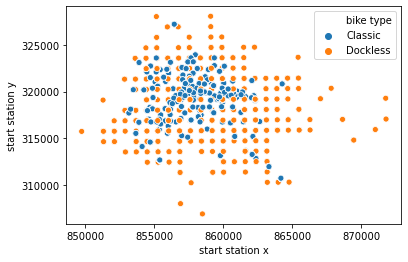

In [67]:
# Scatterplot of station locations and dockless bike 'locations'
sns.scatterplot(x=df['start station x'],y=df['start station y'], hue=df['bike type'])

In [40]:
# create Euclidean distance function
def dist_euc(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# create taxi-cab distance function
def dist_taxi(x1,y1,x2,y2):
    return np.abs(x1-x2) + np.abs(y1-y2)

# Create distance between stations column
#df['station_distance']=np.zeros(len(df))
for j in df.index:
    df.loc[j,'station_distance'] = dist_taxi(df.loc[j,'start station x'], df.loc[j,'start station y'], df.loc[j,'end station x'], df.loc[j,'end station y'])

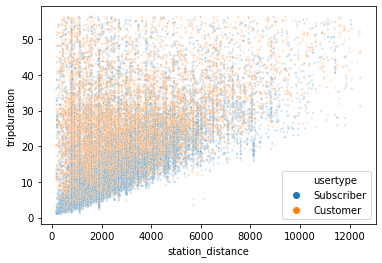

In [219]:
sns.scatterplot(x='station_distance', y='tripduration', hue='usertype', alpha=0.2,
                data=df_go[ df_go['station_distance']<12500], s=5)

# Take out NRM Bike Shop 1 instances
This appears to be a repair shop, not an actual destination.

In [43]:
print(df.shape)
df = df[df['start station name']!='NRM Bike Shop 1']
print(df.shape)

(66326, 25)
(66324, 25)


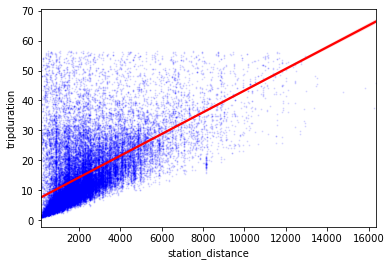

In [220]:
sns.regplot(x='station_distance', y='tripduration', data=df_go[df_go['bike type'] == 'Classic'],
            color = 'blue', scatter_kws={'s':1, 'alpha':0.1}, line_kws={'color':'red'})

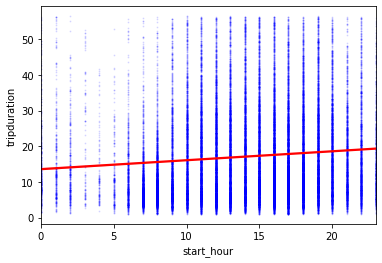

In [95]:
sns.regplot(x='start_hour', y='tripduration', data=df[df['bike type'] == 'Classic'],
            color = 'blue', scatter_kws={'s':1, 'alpha':0.1}, line_kws={'color':'red'})

Clearly, and intuitively, regression is not going to be a fantastic 

In [221]:
corr_matrix = df_go.corr()

In [222]:
corr_matrix['tripduration'].sort_values(ascending=False)

tripduration               1.000000
station_distance           0.584244
enddayofweek               0.159659
startdayofweek             0.159376
temperature                0.105594
end station id             0.085877
start_hour                 0.084889
start station id           0.065002
bikeid                     0.023441
dew_point                  0.009944
wind_speed                 0.003321
precipitation             -0.022554
birth year                -0.048717
end station x             -0.069811
end station longitude     -0.071611
start station x           -0.074397
start station longitude   -0.075930
gender                    -0.099128
start station latitude    -0.183431
start station y           -0.183905
end station latitude      -0.207926
end station y             -0.208347
long_trip                       NaN
Name: tripduration, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d86e8b0>,
      dtype=object)

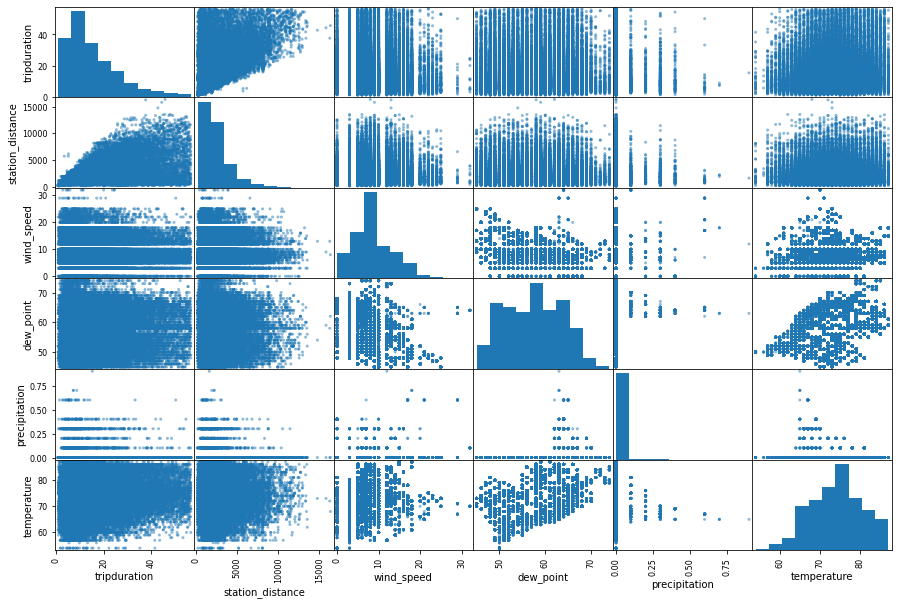

In [224]:
from pandas.plotting import scatter_matrix

atts = ['tripduration',  'station_distance', 'wind_speed',
        'dew_point', 'precipitation','temperature']
scatter_matrix(df_go[atts], figsize=(15,10))

# Problem statement
We want to see if we can predict if a customer will ride a bike longer than 30 minutes. After 30 minutes, additional charges apply. We created a `long_trip` feature for trips longer than 30 minutes (True).

**Note** This problem statement has undergone modification. What follows may not address this precise problem.

## Feature selection.
We have a small issue that `Dockless` bikes do not have start/end stations. For the moment, I am going to restrict my attention to the `Classic` `bike type`.

The features I will use are `start_hour`, `start station latitude`, `start station longitude`, `end station latitude`, `end station longitude`, `usertype`, `birth year`, `gender`, `startdayofweek`. The response variable will be `long_trip`.

# Alternate problem statement
After removing long (2 hours) trips, can we use regression to predict tripduration?

In [259]:
df.columns

Index(['tripduration', 'start_time', 'end_time', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'bike type', 'start_hour', 'startdayofweek',
       'enddayofweek', 'long_trip', 'start station x', 'start station y',
       'end station x', 'end station y', 'station_distance', 'temperature',
       'wind_speed', 'dew_point', 'precipitation'],
      dtype='object')

In [282]:
X = df[['usertype',
       'birth year', 'gender', 'bike type', 'start_hour', 'startdayofweek',
       'enddayofweek', 'start station x', 'start station y',
       'end station x', 'end station y', 'station_distance', 'temperature',
       'wind_speed', 'dew_point', 'precipitation', 'longer_than_median']]

# Trip dataframe to remove dockless bikes
X = X[X['bike type'] == 'Classic']

# Remove 'bike type' column
X.drop(columns='bike type', inplace=True)

X.sample(3)

,usertype,birth year,gender,start_hour,startdayofweek,enddayofweek,start station x,start station y,end station x,end station y,station_distance,temperature,wind_speed,dew_point,precipitation,longer_than_median
53967,Customer,1969,0,14,4,4,859789.164095,313164.362893,859789.164095,313164.362893,0.000000,77.0,10.0,59.0,0.0,True
70030,Customer,1969,0,21,4,4,861606.793986,319476.122225,859297.232607,320641.555838,3474.994992,63.0,5.0,49.0,0.0,True
13788,Customer,1983,2,8,1,1,859670.444207,319240.075972,860159.248081,319554.604418,803.332320,73.0,3.0,63.0,0.0,False


In [283]:
# y is a continuous variable, so it's a regression problem
y = df[df['bike type'] == 'Classic'].tripduration

In [284]:
print(X.shape)
print(y.shape)

(46418, 16)
(46418,)


## Split the data

In [268]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Build the model
Here we will look at LinearRegression

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [285]:
# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Preprocessing for numerical data
numerical_cols = [cname for cname in X.columns if X[cname].dtype != 'object']
numerical_transformer = Pipeline(steps = [('std_scaler',StandardScaler())])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
    ('num', numerical_transformer, numerical_cols), # numerical columns not missing data. May use when trying dockless
    ('cat', categorical_transformer, categorical_cols)
])

# Use Linear Regression
#model = LinearRegression()

# Use Ridge Regression
#model = Ridge(alpha=1.0)

# Use Lasso Regression
#model = Lasso(alpha=1.0)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('std_scaler', StandardScaler()),
    ('model', model)
])

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

print("scores are", cv_scores)
print("average score is", cv_scores.mean())

scores are [6.15694757 5.97308282 6.31497612 6.07165453 5.99225705]
average score is 6.101783616906422


In [286]:
alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]

my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('std_scaler', StandardScaler()),
    ('model', LinearRegression())
])
cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
print('The Linear Regression mean score is', cv_scores.mean())

for alpha in alphas:
    model = Ridge(alpha=alpha)
    my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('std_scaler', StandardScaler()),
    ('model', model)])
    cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
    print('for alpha =', alpha, ', the Ridge Regression mean score is', cv_scores.mean())
    
for alpha in alphas:
    model = Lasso(alpha=alpha)
    my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('std_scaler', StandardScaler()),
    ('model', model)])
    cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
    print('for alpha =', alpha, ', the Lasso Regression mean score is', cv_scores.mean())

The Linear Regression mean score is 5.539391861475016
for alpha = 0.01 , the Ridge Regression mean score is 5.539856207138289
for alpha = 0.03 , the Ridge Regression mean score is 5.53985546169785
for alpha = 0.1 , the Ridge Regression mean score is 5.539852853716664
for alpha = 0.3 , the Ridge Regression mean score is 5.5398454131820465
for alpha = 1.0 , the Ridge Regression mean score is 5.539819483694568
for alpha = 3.0 , the Ridge Regression mean score is 5.539746311864633
for alpha = 0.01 , the Lasso Regression mean score is 5.537989280759649
for alpha = 0.03 , the Lasso Regression mean score is 5.5362806028354905
for alpha = 0.1 , the Lasso Regression mean score is 5.533778229810447
for alpha = 0.3 , the Lasso Regression mean score is 5.545461270748601
for alpha = 1.0 , the Lasso Regression mean score is 5.647767579055759
for alpha = 3.0 , the Lasso Regression mean score is 6.101783616906422


What we can see from this is that Ridge regression and Linear Regression perform very similarly. Lasso Regression performs slightly worse. This is not surprising, as the given features do not seem like they do a great job predicting tripduration.

# Classification
Here we see if we can classify if rides last longer than the median or not. This is a classification problem, so we will apply some of the classification algorithms; Logistic Regression, Random Forests, and Support Vector Machines.

In [287]:
X = df[['usertype',
       'birth year', 'gender', 'bike type', 'start_hour', 'startdayofweek',
       'enddayofweek', 'start station x', 'start station y',
       'end station x', 'end station y', 'station_distance', 'temperature',
       'wind_speed', 'dew_point', 'precipitation']]

# Trip dataframe to remove dockless bikes
X = X[X['bike type'] == 'Classic']

# Remove 'bike type' column
X.drop(columns='bike type', inplace=True)


# y is a boolean response.
y = df[df['bike type'] == 'Classic'].longer_than_median

## Random Forest Regressor
Implement Random Forest Regressor here

In [298]:
from sklearn.ensemble import RandomForestClassifier

# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Preprocessing for numerical data
numerical_cols = [cname for cname in X.columns if X[cname].dtype != 'object']
numerical_transformer = Pipeline(steps = [('std_scaler', StandardScaler())])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Use Random Forest Classifier
model = RandomForestClassifier(n_estimators = 500)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
cv_scores = cross_val_score(my_pipe, X, y, cv=5, scoring='accuracy')

print("accuracy scores are", cv_scores)
print("for Random Forest Regressor, average score is", cv_scores.mean())

accuracy scores are [0.80364067 0.82001293 0.80751831 0.79661747 0.81880857]
for Random Forest Regressor, average score is 0.8093195912547955


# Logistic Regression

In [295]:


# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Preprocessing for numerical data
numerical_cols = [cname for cname in X.columns if X[cname].dtype != 'object']
numerical_transformer = Pipeline(steps = [('std_scaler', StandardScaler())])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Use Logistic Regression
model = LogisticRegression(max_iter=10000, solver='lbfgs', C=0.05)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])


cv_scores = cross_val_score(my_pipe, X, y, cv=5, scoring='accuracy')

print("accuracy scores are", cv_scores)
print("for Logistic Regression, average score is", cv_scores.mean())

accuracy scores are [0.72404136 0.74924601 0.72748815 0.72013358 0.73952386]
for Logistic Regression, average score is 0.7320865932235745


In [296]:
c_vals = [0.01, 0.03, 0.1, 0.3, 1, 3]
for c in c_vals:
    model = LogisticRegression(max_iter=10000, solver='lbfgs', C=c)
    my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)])
    cv_scores = cross_val_score(my_pipe, X, y, cv=5, scoring='accuracy')
    print("for Logistic Regression and C value",c,", average score is", cv_scores.mean())
    

for Logistic Regression and C value 0.01 , average score is 0.7329914243782432
for Logistic Regression and C value 0.03 , average score is 0.732172774581157
for Logistic Regression and C value 0.1 , average score is 0.7320650484643372
for Logistic Regression and C value 0.3 , average score is 0.7321081333415453
for Logistic Regression and C value 1 , average score is 0.7320865909029413
for Logistic Regression and C value 3 , average score is 0.7321081333415453


We see that Random Forests is outperforming Logistic Regression here, using an accuracy metric. Logistic Regression gives about 73% accuracy while Random Forests gives about 80%.

## K Nearest Neighbors
KNN is used for a categorical response variable.
Here we try the KNN model. We will look at several different N values

In [297]:
# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Preprocessing for numerical data
numerical_cols = [cname for cname in X.columns if X[cname].dtype != 'object']
numerical_transformer = Pipeline(steps = [('std_scaler', StandardScaler())])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Use KNN
model = KNeighborsClassifier(n_neighbors=10)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])



# Use KNN
# Loop through 2 to 20 neighbors
n_scores=[]
for n in range(2,20):
    model = KNeighborsClassifier(n_neighbors=n)
    # Construct pipeline
    my_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', model)])
    
    cv_scores = cross_val_score(my_pipe, X, y, cv=5, scoring='accuracy')
    
    print("for ",n, "neighbors, scores are", cv_scores)
    print("average score is", cv_scores.mean())
    n_scores.append(cv_scores.mean())

plt.plot(range(len(n_scores)),n_scores)

accuracy scores are [0.7287807  0.72156398 0.73395088 0.71830227 0.73306043]
for Logistic Regression, average score is 0.7271316536558816
for  2 neighbors, scores are [0.67514003 0.67061611 0.68688065 0.67251966 0.68813961]
average score is 0.6786592128235595
for  3 neighbors, scores are [0.6943128  0.7022835  0.71294701 0.70225143 0.72864376]
average score is 0.708087697009581
for  4 neighbors, scores are [0.69862128 0.68644981 0.70896165 0.69449531 0.71011526]
average score is 0.6997286645966928
for  5 neighbors, scores are [0.71036191 0.71370099 0.72393365 0.71280836 0.73079823]
average score is 0.71832062918123
for  6 neighbors, scores are [0.70863852 0.70777682 0.7226411  0.70138964 0.72261122]
average score is 0.7126114605959024
for  7 neighbors, scores are [0.72037915 0.72684188 0.72953468 0.71076161 0.73941614]
average score is 0.7253866906019877
for  8 neighbors, scores are [0.71704007 0.71693236 0.727919   0.71022299 0.7311214 ]
average score is 0.7206471638171689
for  9 neig

AttributeError: 'list' object has no attribute 'plot'

In [300]:
from sklearn.svm import SVC

# Use SVC
model = SVC(C=1.0)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])


cv_scores = cross_val_score(my_pipe, X, y, cv=5, scoring='accuracy')

print("accuracy scores are", cv_scores)
print("for SVM, average score is", cv_scores.mean())

accuracy scores are [0.77369668 0.77843602 0.76034037 0.75654422 0.78358289]
for SVM, average score is 0.770520037206249


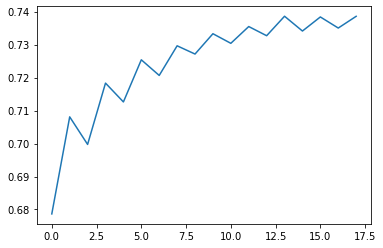

In [303]:
plt.plot(range(len(n_scores)),n_scores)

In [304]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(RandomForestClassifier(n_estimators = 100).fit(X_train, y_train), X_test, y_test)

ValueError: could not convert string to float: 'Subscriber'